# Google Scholar Trend Crawling
This code is a cleaned up version of `1. Scholar_Scraping.ipynb`. You may find extra comments there


## *Google Scholar Parser Check List*
<input type="checkbox" checked> Parse proxy list \
<input type="checkbox" checked> Avoid google detection and CAPTCHA page dynamically \
<input type="checkbox" checked>  Fix citations with different languages since they depend on proxy location \
<input type="checkbox" checked > Source links are more than expected at times - this screws up the "Source" column, so be careful about it \
(<input type="checkbox" checked >) Use multi-threading / multi-processing to speed up the huge for loop ~~(currently it takes >4 hours)~~ with this less than 30 minutes! \
<input type="checkbox" checked> Use shared dataframe to improve proxy checking stats and efficiency (does not work in the `multiprocessing` part): adjust dynamically \
<input type="checkbox" checked> Database creation divided by keyword type \
<input type="checkbox" checked > Bibtex parsing: database will be more reliable and include all the information\
<input type="checkbox" checked> Author profile parsing: parse info about first author \
<input type="checkbox"checked > Journal database merging: merge data with the Journal IF database \


Problem to solve with Bibtex parsing \
<input type="checkbox" checked> Years is sometimes 0 if the publisher contains a "-" (e.g. diva-portal.org) \
<input type="checkbox" checked> If the word has some problems, such as "Hemocopatible coating" (in this case a misspelling) and Google suggests another one, then the code fucks it up -> either check always that words are correct, or we should make some extra code for fixing this \

### NOTE
Compared to before, the code takes much more: around 20 minutes for ~100 results instead of 3/4 minutes before. The reason for this is that we are checking for the bibtex in each page (10 links instead of 1) plus ~10 links for the authors. In total, it is around 100 times more than before


In [1]:
import sys
import os
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np
from tqdm.notebook import tqdm # notebook version, a bit cooler
from warnings import warn
import multiprocessing # speed up the crawler
from tabulate import tabulate # fancify some stuff
import re
import urllib

In [2]:
# Execute first
!pip install mysql
!pip install mysql-connector-python

## Crawling the Journal Impact Factor

In [3]:
IF_year = '2021'
IF_month = '07'
headers = {"User-Agent":"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36", 'Referer':'https://www.google.com/'}

url = 'https://impactfactorforjournal.com/wp-content/uploads/'+ IF_year +'/'+ IF_month +'/JCR2021.xlsx'
filename = "JCR"+IF_year+".xlsx"
response = requests.get(url, headers=headers)
output = open(filename, 'wb')
output.write(response.content)
output.close()
IF_database = pd.read_excel(filename, header=2, index_col=0)
IF_database


,Full Journal Title,Total Cites,Journal Impact Factor,Eigenfactor Score
Rank,,,,
1,CA-A CANCER JOURNAL FOR CLINICIANS,55868,508.702,0.10514
2,NATURE REVIEWS MOLECULAR CELL BIOLOGY,58477,94.444,0.07548
3,NEW ENGLAND JOURNAL OF MEDICINE,464351,91.245,0.63118
4,NATURE REVIEWS DRUG DISCOVERY,41989,84.694,0.04822
5,LANCET,369601,79.321,0.44524
...,...,...,...,...
12982,JCO Oncology Practice,318,Not Available,0.00000
12982,JOURNAL OF POLYMER SCIENCE,2165,Not Available,0.00003
12982,Joint Diseases and Related Surgery,0,Not Available,0.00000


Text(0.5, 0.9, 'Journal Rank')

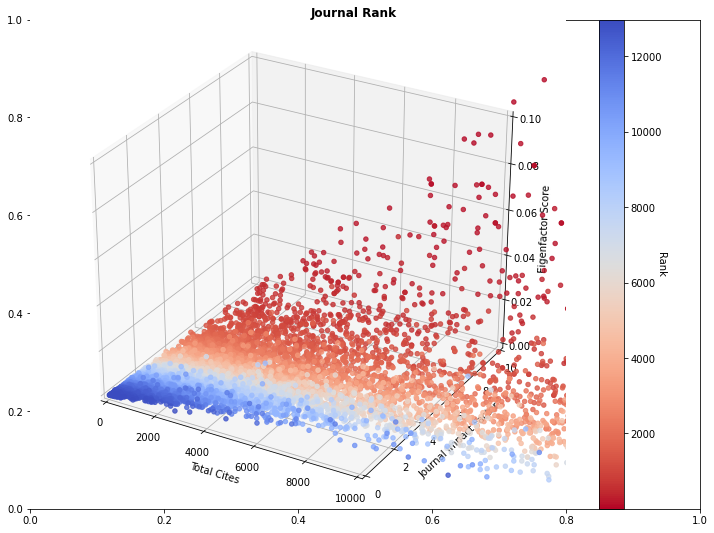

In [4]:
IF_mod = IF_database[pd.to_numeric(IF_database['Journal Impact Factor'], errors='coerce').notnull()]

fig, axs = plt.subplots(1, 1, figsize=(12, 9) )
ax = fig.add_subplot(111, projection='3d')

p = ax.scatter(IF_mod['Total Cites'], IF_mod['Journal Impact Factor'], IF_mod['Eigenfactor Score'], c=IF_mod.index, cmap='coolwarm_r')
ax.set_xlim(0, .1e5)
ax.set_ylim(0, 0.1e2)
ax.set_zlim(0, 0.1)
ax.set_xlabel('Total Cites')
ax.set_ylabel('Journal Impact Factor')
ax.set_zlabel('Eigenfactor Score')
cb = fig.colorbar(p)
cb.set_label('Rank', rotation=270)

fig.suptitle('Journal Rank', fontweight='bold', y=0.9)

## Merge Journals and the parsed data

In [5]:
tqdm.pandas()
from difflib import SequenceMatcher
from heapq import nlargest as _nlargest

def get_close_matches_indexes(word, possibilities, n=3, cutoff=0.6):
    """Use SequenceMatcher to return a list of the indexes of the best 
    "good enough" matches. word is a sequence for which close matches 
    are desired (typically a string).
    possibilities is a list of sequences against which to match word
    (typically a list of strings).
    Optional arg n (default 3) is the maximum number of close matches to
    return.  n must be > 0.
    Optional arg cutoff (default 0.6) is a float in [0, 1].  Possibilities
    that don't score at least that similar to word are ignored.
    """

    if not n >  0:
        raise ValueError("n must be > 0: %r" % (n,))
    if not 0.0 <= cutoff <= 1.0:
        raise ValueError("cutoff must be in [0.0, 1.0]: %r" % (cutoff,))
    result = []
    s = SequenceMatcher()
    s.set_seq2(word)
    for idx, x in enumerate(possibilities):
        s.set_seq1(x)
        if s.real_quick_ratio() >= cutoff and \
           s.quick_ratio() >= cutoff and \
           s.ratio() >= cutoff:
            result.append((s.ratio(), idx))

    # Move the best scorers to head of list
    result = _nlargest(n, result)

    # Strip scores for the best n matches
    return [x for score, x in result]

def search_and_insert_impact_factor(df, journals):
  """Do a fuzzy search over the Journal dataframe and return the best match for the Journal impact factor"""
  journal_list = list(map(lambda x: x.lower(), journals['Full Journal Title'].tolist()))
  
  # Obtain indexes of the closes match with fuzzy search
  def _get_matches(x):
    try:
      return get_close_matches_indexes(x.lower(), journal_list, cutoff=0.6)[0]
    except:
      return 'Could not find matching journal'
  indexes = df['Journal'].progress_apply(_get_matches)
  
  # Obtain the impact factor via the indexes
  def _parse_impact_factor(idx):
    try:
      return journals.iloc[idx]['Journal Impact Factor']
    except:
      return 'Could not find matching journal'
  impact_factors = list(map(lambda x: _parse_impact_factor(x), indexes))
  df.insert(8, column='Journal Impact Factor', value=impact_factors)
  return df

## AWS connection and saving

Here is the data for database connection. Remember to install `mysql` beforehand

In [6]:
# Data
config = {
  'database':'gscholar',
  'user':'admin',
  'password':'cgbio12#$',
  'endpoint':'cgbio-keyword.ci2chv7x8rmn.us-east-2.rds.amazonaws.com',
  'port':'3306',
}

## SQL utils

In [7]:
from sqlalchemy import create_engine
from sqlalchemy import text

DATABASE = 'gscholar'
engine = create_engine("mariadb://{}:{}@{}:{}/{}?charset=utf8".format(config['user'], config['password'], config['endpoint'], config['port'], config['database']), encoding='utf8')

# with engine.connect() as conn:
#   result = conn.execute(text("SHOW DATABASES;"))
#   # result = conn.execute(text("SHOW DATABASES;"))

#   print(result.all())

def to_sql(df, name='data', config=config, **kwargs):
  """Transfer data to sql database
  Args:
    df: pandas dataframe
    bane: name of MariaDB table
    config: configuration for the server connection as above
    **kwargs: to_sql pandas method keyword arguments
  """
  try:
    # Create engine
    df = create_engine("mariadb://{}:{}@{}:{}/{}?charset=utf8".format(
        config['user'], config['password'], config['endpoint'], config['port'], config['database']), encoding='utf8')
    # Correctly encode characters
    df.replace({r'[^\x00-\x7F]+':''}, regex=True, inplace=True)
    # Send
    df.to_sql(con=engine, name=name, if_exists='append',chunksize=100, index=False, **kwargs)
    return True # successful
  except: 
    return False # not successful 

## Create proxies dataframe

Update: now we scrape proxies ourselves and use `socks` protocols, which seem to cut time in around half!


### Method 1: read database for proxies

In [8]:
# print("mariadb://{}:{}@{}:{}/{}".format(config['user'], config['password'], config['endpoint'], config['port'], config['database']))

In [20]:
engine = create_engine("mariadb://{}:{}@{}:{}/{}".format(config['user'], config['password'], config['endpoint'], config['port'], 'gscholar'))

with engine.connect() as conn:
  result = conn.execute(text("USE gscholar;"))
  result = conn.execute(text("CREATE TABLE data"))
  print(result.all())

ProgrammingError: ignored

In [9]:
from sqlalchemy import create_engine
from sqlalchemy import text

DATABASE = 'proxies'
TABLE_NAME = 'proxies'
engine = create_engine("mariadb://{}:{}@{}:{}/{}".format(config['user'], config['password'], config['endpoint'], config['port'], 'proxies'))

with engine.connect() as conn:
  result = conn.execute(text("USE proxies;"))
  result = conn.execute(text("SHOW TABLES;"))

  print(result.all())

proxies = pd.read_sql(TABLE_NAME, engine)

# Modify the dataset
# let's remove Chinese servers (CCP blocks access to Scholar too, lol)
proxies = proxies[proxies['Country'] != 'China']
proxies = proxies.assign(Success=0, Blocked=0, Timeout=0) # add extra metrics to the dataframe to get the best server

# Randomize
proxies = proxies.sample(frac=1).reset_index(drop=True)
proxies

[('proxies',)]


,Protocol,Address:port,Country,Region,City,Success,Blocked,Timeout
0,socks4,80.91.120.38:5678,Albania,None,None,0,0,0
1,http,202.169.252.253:8181,Indonesia,Bali,Gianyar,0,0,0
2,socks4,91.105.135.113:1080,Russia,Novosibirsk Oblast,Suzun,0,0,0
3,socks4,103.241.227.106:6667,India,Gujarat,Ahmedabad,0,0,0
4,socks4,168.90.76.220:5678,Brazil,Bahia,Guanambi,0,0,0
...,...,...,...,...,...,...,...,...
1855,socks4,95.86.37.1:59341,North Macedonia,Resen,Resen,0,0,0
1856,socks4,216.154.201.132:54321,United States,Florida,Pompano Beach,0,0,0
1857,socks4,102.141.91.245:5678,South Africa,Limpopo,Phalaborwa,0,0,0
1858,http,51.81.32.81:8888,United States,None,None,0,0,0


### Method 2: directly create from source files

In [10]:
# # We use the generated proxies via proxy scraper
# # Upload or create beforehand the necessary files
# protocols = ['http', 'socks4', 'socks5']

# for p, i in zip(protocols, range(len(protocols))):
#   filename = p+'.txt'
#   proxies_raw = pd.read_csv(filename,  sep="::", names=["Address:port", "Country", "Region", "City"])
#   proxies_raw.insert(0, "Protocol", p)
#   if i == 0: proxies = proxies_raw
#   else: proxies = pd.concat([proxies, proxies_raw])

# # Modify the dataset
# # let's remove Chinese servers (CCP blocks access to Scholar too, lol)
# proxies = proxies[proxies['Country'] != 'China']
# proxies = proxies.assign(Success=0, Blocked=0, Timeout=0) # add extra metrics to the dataframe to get the best server

# # Randomize
# proxies = proxies.sample(frac=1).reset_index(drop=True)
# proxies

In [11]:
# # List is not updated for now
# # Get free proxies
# url = "https://raw.githubusercontent.com/monosans/proxy-list/main/proxies_geolocation/http.txt" 
# proxies_raw = pd.read_csv(url,  sep="::", names=["Address:port", "Country", "Region", "City"])

# # Modify the dataset
# # let's remove Chinese servers (CCP blocks access to Scholar too, lol)
# proxies = proxies_raw[proxies_raw['Country'] != 'China']
# proxies = proxies.assign(Success=0, Blocked=0, Timeout=0) # add extra metrics to the dataframe to get the best server
# proxies.reset_index(drop=True, inplace=True)
# proxies

## Proxy utils

In [12]:
# soup = BeautifulSoup(str('<html><head><meta content="text/html; charset=utf-8" http-equiv="content-type"/><title>Sorry...</title><style> body { font-family: verdana, arial, sans-serif; background-color: #fff; color: #000; }</style></head><body><div><table><tr><td><b><font face="sans-serif" size="10"><font color="#4285f4">G</font><font color="#ea4335">o</font><font color="#fbbc05">o</font><font color="#4285f4">g</font><font color="#34a853">l</font><font color="#ea4335">e</font></font></b></td><td style="text-align: left; vertical-align: bottom; padding-bottom: 15px; width: 50%"><div style="border-bottom: 1px solid #dfdfdf;">Sorry...</div></td></tr></table></div><div style="margin-left: 4em;"><h1>Were sorry...</h1><p>... but your computer or network may be sending automated queries. To protect our users, we cant process your request right now.</p></div><div style="margin-left: 4em;">See <a href="https://support.google.com/websearch/answer/86640">Google Help</a> for more information.<br/><br/></div><div style="text-align: center; border-top: 1px solid #dfdfdf;"><a href="https://www.google.com">Google Home</a></div></body></html>'))
# title = soup.title.text
# print(title.lower())

In [13]:
# Anti-detection utils

timeout = 10 # proxy timeout
headers = {"User-Agent":"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36", 'Referer':'https://www.google.com/'}
session = requests.Session()

# headers = {"User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36",
#            'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
#             'Accept-Language': 'en-US,en;q=0.5',
#             'DNT': '1',
#             'Connection': 'keep-alive',
#             'Upgrade-Insecure-Requests': '1',
#              'referer':'https://www.google.com/'}
# }

# Randomize time with a uniform distribution, we should adjust the times depending on the detection rate
def _random_time(low=0.6, high=3.0):
  return np.random.uniform(low=low, high=high, size=None)

# Function to order proxy reliability
def _move_row(df, idx, to='first'):
  """Move dataframe row. Rough implementation, maybe there is a cleaner way
  but this seems to get the job done
  Args:
    df: dataframe
    idx: index of the row
    to: position, either 'first' or 'last'
  """
  size = len(df)
  if idx >= size-1:
    return df # cannot move this one
  else:
    reindexing = np.arange(size)
    if to is 'first':
      reindexing[:idx+1] -= 1
      reindexing[0] = idx
    elif to is 'last':
      reindexing[idx:] += 1
      reindexing[size-1] = idx
    else:
      warn(f'Keyword {to} has no effect for now')
      return df # cannot move this one
    df = df.reindex(reindexing)
    df.reset_index(drop=True, inplace=True)
  return df

# Captcha detection
def _detect_captcha(soup):
  """Detect if the webpage (Google in this case) is asking for the Captcha code"""
  # captcha = soup.find("form", id="gs_captcha_f")
  captcha = soup.select('form[id*="captcha"]') # this should recognize every form containing captcha
  if captcha:
    return True
  else:
    return False

# Other errors detection
def _check_error(soup):
  """Detect if keyword 'Error' and 'sorry' is in Google's title with a code"""
  try:
    title = soup.title.text
    # code = ([int(s) for s in title.split() if s.isdigit()])[0]
    error, code = title.split(' ')[0],  title.split(' ')[1]
    if error.lower() == 'error' and int(code)>399:
      return True
    if title.lower() == 'sorry...':
      return True
  except:
    return False # success 
  return False # no error detected


# Obtain webpage with some tricks
def proxy_get(url):
  """Iterate over proxy dataframe to obtain a valid webpage
  The function does the following:
    - Check for working pages
    - Check for captcha
    - Change non-working proxies position so they aren't checked again
    - Random sleep to avoid re-detection with same proxy
    - Metrics saving
  Args:
    url: url to search for in string format
    proxies: pandas dataframe containing the proxies

  NOTE: still a rough implementation, some stuff is subject to change. Feedback is welcome :)
  """
  global proxies
  for index, proxy_row in proxies.iterrows():
    proxy = {'https': str(proxy_row['Protocol'])+'://'+str(proxy_row['Address:port'])}
    try:
      page = session.get(url, proxies=proxy, headers=headers, timeout=timeout) # use proxy to avoid detection
    except:
      # Timeout proxy becomes last in the dataframe, so we don't retry it
      proxies.loc[index, 'Timeout'] += 1 # increase timeouts number
      proxies = _move_row(proxies, index, to='last')
      continue
    else:
      c = page.content
      soup = BeautifulSoup(c, 'html.parser') # parser
      if _detect_captcha(soup) or _check_error(soup):
        # Proxy with CAPTCHA verification becomes last in the dataframe, so we don't retry it
        # Can also be due to an error e.g. 403 or 429
        proxies.loc[index, 'Blocked'] += 1 # increase blocked number
        proxies = _move_row(proxies, index, to='last')
        continue
      else:
        proxies.loc[index, 'Success'] += 1 # increase success number
        break
  # Randomize time between requests
  time.sleep(_random_time())
  return soup

## Scholar utilities

This is what the algorithm sees when parsing the data. We are interested in the Vancouver one since it has more data

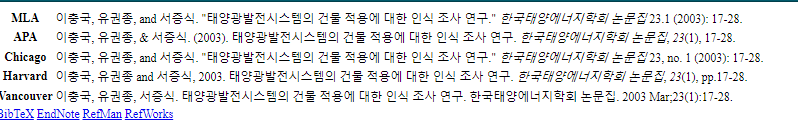

In [42]:
def get_citations(content):
    """Parse content with "/scholar?cites, so it works in multiple languages"""
    try:
      item = content.find_all("a", href=lambda href: href and href.startswith("/scholar?cites"))[0]
      if hasattr(item, 'string'):
        # Needed for e.g. Thai language in which there is no space or Chinese in which the counter 次 screws up the count
        citations = item.string.replace(" ", "") 
        citations = int(re.findall(r"\d+", citations)[0])
    except:
      citations = 0 # if citations could not be parsed this is the default return value
    return citations

# def get_year(content):
#     for char in range(0,len(content)):
#       if content[char] == '-':
#         out = content[char-5:char-1]
#     if not out.isdigit():
#         out = 0
#     return int(out)

# def get_author(content):
#     for char in range(0,len(content)):
#         if content[char] == '-':
#             out = content[2:char-1]
#             break
#     return out


In [43]:
def get_vancouver_data(url) -> str:
    """Retrieves the citation data in Vancouver style
    Another method would be to obtain the link of the Bibtex file like in https://github.com/scholarly-python-package/scholarly
    However this above requires one more link to be reached (double time) also increasing possibility of detection, so we
    just directly parse data in this way
    Some extra checks for certain articles may be required
    """
    page = proxy_get(url) # use proxy to avoid detection
    table = page.find('table')
    last_row = table("tr")[-1] # select Vancouver
    text = last_row.text
    # Parse data from the single string
    splitting = text.split('.')
    author = splitting[0][9:]
    journal = splitting[-3].lstrip()
    title = ' '.join(splitting[1:((len(splitting)-3))]).lstrip()
    others = splitting[-2].lstrip().split(';')
    date = others[0]
    date = date.split(' ')
    year = date[0]
    try:
      month = date[1]
    except:
      month = None
    try:
      day = date[2]
    except:
      day = None
    extra = others[-1]
    return {'author': author, 'title': title, 'journal': journal, 'year':year, 'month':month, 'day':day, 'extra': extra}

In [44]:
def get_author_data(profile_url) -> str:
  """Obtain author data given profile url"""
  coauthors = list()
  soup = proxy_get(profile_url) # use proxy to avoid detection
  name = soup.find('div', id='gsc_prf_in').text
  affiliation = soup.find('div', class_='gsc_prf_il').text
  interests = [i.text.strip() for i in
                    soup.find_all('a', class_='gsc_prf_inta')]

  index = soup.find_all('td', class_='gsc_rsb_std')
  if index:
      citedby = int(index[0].text)
      citedby5y = int(index[1].text)
      hindex = int(index[2].text)
      hindex5y = int(index[3].text)
      i10index = int(index[4].text)
      i10index5y = int(index[5].text)
  else:
      hindex = 0
      hindex5y = 0
      i10index = 0
      i10index5y = 0

  try:
    for row in soup.find_all('span', class_='gsc_rsb_a_desc'):
        new_coauthor_name = row.find(tabindex="-1").text
        new_coauthor_affiliation = row.find(class_="gsc_rsb_a_ext").text
        coauthors.append({'name': new_coauthor_name, 'affiliation': new_coauthor_affiliation})
  except:
    coauthors.append(None)

  return {'url': profile_url, 'name': name, 'affiliation': affiliation, 
          'interests': interests, 'citedby': citedby, 'citedby5y':citedby5y, 
          'hindex':hindex, 'hindex5y':hindex5y, 'i10index':i10index, 'i10index5y':i10index5y, 'coauthors': coauthors}


In [45]:
# author_data = get_author_data('https://scholar.google.com/citations?user=Z7SRkrIAAAAJ&hl=en&oi=sra')
# author_data

## Single Keyword Test

In [ ]:
# Start new session
_CITE_URL = 'https://scholar.google.com/scholar?q=info:{0}:scholar.google.com/&output=cite&scirp={1}&hl=en'
_USER_URL = 'https://scholar.google.com{0}'

keyword = 'Bioresorbable Vascular Stent'
session = requests.Session()
path = './'+keyword+'_result_cgbio.csv' # path to save the data
number_of_results = 100
save_database = True

links = list()
citations = list()
rank = list()
title = list()
author = list()
year = list()
journal = list()
article_summary = list()
month = list()
day = list()
extra = list()
first_author_hindex = list()
first_author_profile = list()

rank.append(0) # initialization necessary for incremental purposes

for n in tqdm(range(0, number_of_results, 10)):    
    url = 'https://scholar.google.com/scholar?start='+str(n)+'&q='+keyword.replace(' ','+')
    soup = proxy_get(url)
    # Get stuff
    mydivs = soup.findAll("div", { "class" : "gs_r" })
    
    i = 0 # position counter for cids
    for div in mydivs:
        try:
            links.append(div.find('h3').find('a').get('href'))
        except Exception as e: # catch *all* exceptions
            # If the above fails, we should not append anything or we introduce dummy variables
            # links.append('no link')
            continue 

        cid = div.get('data-cid')
        if cid is None:
          # remove last element of links so not to mess up database
          continue
        bib_url = _CITE_URL.format(cid, i)
        try:
          data = get_vancouver_data(bib_url)
        except:
          links.pop() # remove last element of links so not mess up database
          print(proxy_get(bib_url)) # print for debug what the page was
          continue
        print(data)
        # Append parsed article in Vancouver data format
        title.append(data['title'])
        author.append(data['author'])
        year.append(data['year'])
        journal.append(data['journal'])
        month.append(data['month'])
        day.append(data['day'])
        extra.append(data['extra'])
        citations.append(get_citations(div))
        rank.append(rank[-1]+1)
        article_summary.append(div.find('div', {'class': 'gs_rs'}).text)
        i += 1 # increase position counter for cids

        # Parse first author information
        try:
          profile_url = _USER_URL.format(div.find('div',{'class' : 'gs_a'}).select_one("a")['href'])
          first_author = get_author_data(profile_url)
          first_author_hindex.append(first_author['hindex'])
          first_author_profile.append([first_author])
        except:
          first_author_hindex.append('Could not find author profile link')
          first_author_profile.append('Could not find author profile link')

print(len(links), len(title), len(citations), len(year), len(author), len(article_summary), len(first_author_profile))

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
# Create a dataset and sort by the number of citations
data = pd.DataFrame(zip(author, title, citations, year, month, day, links, journal, first_author_hindex, extra, article_summary, first_author_profile), index = rank[1:], 
                    columns=['Author', 'Title', 'Citations', 'Year', 'Month', 'Day', 'Link', 'Journal', 'First Author h-index', 'Extra', 'Summary', 'First Author Profile'])
data.index.name = 'Rank'

# Merge with the Impact Factor Data, this will take some time
data = search_and_insert_impact_factor(data, IF_database)
data_ranked = data.sort_values('Citations', ascending=False)

# Plot by citation number
plt.plot(rank[1:],citations,'*')
plt.ylabel('Number of Citations')
plt.xlabel('Rank of the keyword on Google Scholar')
plt.title('Keyword: '+keyword)

# Save results
if save_database:
    data_ranked.to_csv(path, encoding='utf-8-sig') # Change the path

In [ ]:
proxies

## Create keywords dataframe


In [14]:
# Keywords dataframe
# Note: do NOT insert special characters such as "/" otherwise the progam may crash
keywords = pd.DataFrame(columns=['Research Team', 'Technical Keywords', 'Product Keywords', 'ETC'])
for i in range(10):
  keywords = keywords.append({'Research Team': 'Team ' + str(i+1)}, ignore_index=True)
keywords.set_index('Research Team', inplace=True, drop=True)
keywords['Technical Keywords']['Team 1'] = ['연골재생','TGF beta-3', 'BMP-2', '생체재료', '의료기기', '골재생']
keywords['Product Keywords']['Team 1']   = ['골이식재', '연골대체재', '연골활액', '치과용', '이식재']
keywords['Technical Keywords']['Team 2'] = ['유착방지제', '지혈제', '드레싱제', '점착성투명창상피복재', '콜라겐']
keywords['Product Keywords']['Team 2']   = ['온도감응', '혈액응고', '가피', '흉터','주름 개선','세포, 진피','(연)조직 재생']
keywords['ETC']['Team 2']                = ['차세대', '신규', '혁신', '차별', '경쟁력', '가성비', '재생', '의료기기']
keywords['Technical Keywords']['Team 3'] = ['광 조사' , '맞춤형 피부 케어', 'EGF' , 'NPWT(음압상처치료)','혈액 튜브', '박동형 펌프', '항응고 코팅', '욕창 예방 시스템', '원심분리', '음압 마사지']
keywords['Product Keywords']['Team 3']   = ['의료용흡인기', '광선조사기', '조합자극기', '가슴체적측정기', '체외막심폐순환보조장치', '골수처리기구', '창상피복재']
keywords['Technical Keywords']['Team 4'] = ['spine', 'spinal implant', 'spinal fusion device surface treatment', 'hydrophilic', 'spinal technology', 'technologies', '3D printing', 'navigation', 'innovative', 'innovation', 'platform', 'development', 'digital surgery', 'guide', 'image guided', 'robotic guided']
keywords['Product Keywords']['Team 4']   = ['Expandable cage', '3D printing cage', 'VBR', 'vertebral body replacement', 'ADR', 'artificial disc replacement', 'TDR', 'total disc replacement', 'joint replacement', 'MIS', 'minimal invasive surgery', 'percutaneous', 'pedicle screw', 'pediatric screw', 'deformity surgery', 'cervical screw', 'occipital plate', 'ACP', 'anterior cervical plate', 'translation plate']
keywords['Technical Keywords']['Team 5'] = ['형상기억합금', '레이저 가공', '전해연마', '화학연마', '혈관 재생', '기계적 혈전 제거술', '코일 색전술', '전기 절제 도자술']
keywords['Product Keywords']['Team 5']   = ['뇌혈관용 스텐트', '전극카테터', '색전 제거 스텐트', '마이크로카테터', '풍선카테터', '소화기', '스텐트']
keywords['ETC']['Team 5']                = ['뇌혈관 중재시술 의료기기', '소화기 질환 치료 의료기기', '혈관 재생 의료기기']
keywords['Technical Keywords']['Team 6'] = ['hemocompatible coating', 'Very late thrombosis', 'thin strut', 'Scaffold coverage', 'PCI', 'Compliance, Scaffold']
keywords['Product Keywords']['Team 6']   = ['Bioresorbable Vascular Stent', 'Poly L-lacticacid', 'OTW Balloon', 'suction catheter', 'delivery system', 'Balloon catheter DES', 'DEB']
keywords['ETC']['Team 6']                = ['AI medical device']
keywords['Technical Keywords']['Team 7'] = ['필러', '히알루론산', '가교']
keywords['Product Keywords']['Team 7']   = ['다나에', '페이스템']
keywords['Technical Keywords']['Team 8'] = ['진피(Dermis)', '줄기세포(stem cells)', '기질혈관분획(stromal vascular fraction, SVF)']
keywords['Product Keywords']['Team 8']   = ['셀루닛']
keywords['Technical Keywords']['Team 9'] = ['맞춤형 임플란트', '3d프린팅 다공체', '3d프린팅 임플란트', '3d프린팅 의료기기']
keywords['Product Keywords']['Team 9']   = ['3d프린팅 임플란트', '3d프린팅 생체재료', '설계 클라우드 시스템']
keywords['Technical Keywords']['Team 10']= ['bio 3d print', 'bio 3d fabrication', 'ceramic print', 'ai 3d print', '3d print qc']

keywords_dataframe = keywords
number_of_results = 100

keywords_dataframe

,Technical Keywords,Product Keywords,ETC
Research Team,,,
Team 1,"[연골재생, TGF beta-3, BMP-2, 생체재료, 의료기기, 골재생]","[골이식재, 연골대체재, 연골활액, 치과용, 이식재]",NaN
Team 2,"[유착방지제, 지혈제, 드레싱제, 점착성투명창상피복재, 콜라겐]","[온도감응, 혈액응고, 가피, 흉터, 주름 개선, 세포, 진피, (연)조직 재생]","[차세대, 신규, 혁신, 차별, 경쟁력, 가성비, 재생, 의료기기]"
Team 3,"[광 조사, 맞춤형 피부 케어, EGF, NPWT(음압상처치료), 혈액 튜브, 박동...","[의료용흡인기, 광선조사기, 조합자극기, 가슴체적측정기, 체외막심폐순환보조장치, 골...",NaN
Team 4,"[spine, spinal implant, spinal fusion device s...","[Expandable cage, 3D printing cage, VBR, verte...",NaN
Team 5,"[형상기억합금, 레이저 가공, 전해연마, 화학연마, 혈관 재생, 기계적 혈전 제거술...","[뇌혈관용 스텐트, 전극카테터, 색전 제거 스텐트, 마이크로카테터, 풍선카테터, 소...","[뇌혈관 중재시술 의료기기, 소화기 질환 치료 의료기기, 혈관 재생 의료기기]"
Team 6,"[hemocompatible coating, Very late thrombosis,...","[Bioresorbable Vascular Stent, Poly L-lacticac...",[AI medical device]
Team 7,"[필러, 히알루론산, 가교]","[다나에, 페이스템]",NaN
Team 8,"[진피(Dermis), 줄기세포(stem cells), 기질혈관분획(stromal ...",[셀루닛],NaN
Team 9,"[맞춤형 임플란트, 3d프린팅 다공체, 3d프린팅 임플란트, 3d프린팅 의료기기]","[3d프린팅 임플란트, 3d프린팅 생체재료, 설계 클라우드 시스템]",NaN


## Run code for all the keywords and organize them
We use `multiprocessing` over all the teams to execute the code in parallel

In [15]:
_CITE_URL = 'https://scholar.google.com/scholar?q=info:{0}:scholar.google.com/&output=cite&scirp={1}&hl=en'
_USER_URL = 'https://scholar.google.com{0}'

# List of keywords to parse
def crawl_scholar(keywords, team='Team Template', category='Type Template',
                  number_of_results=100, save_local=True, save_sql=True):
  """Main crawling function, diving the data into team and type"""

  # Create directory
  dir_name = './'+team+'/'+category
  if not os.path.exists(dir_name):
      os.makedirs(dir_name)

  for keyword in keywords:
    """Search Google Scholar for keywords and return dataframe"""

    session = requests.Session()
    path = dir_name+keyword+'_result_cgbio.csv' # path to save the data

    links = list()
    citations = list()
    rank = list()
    title = list()
    author = list()
    year = list()
    journal = list()
    article_summary = list()
    month = list()
    day = list()
    extra = list()
    first_author_hindex = list()
    first_author_profile = list()

    rank.append(0) # initialization necessary for incremental purposes

    for n in tqdm(range(0, number_of_results, 10)):    
        url = 'https://scholar.google.com/scholar?start='+str(n)+'&q='+keyword.replace(' ','+')
        soup = proxy_get(url)
        # Get stuff
        mydivs = soup.findAll("div", { "class" : "gs_r" })
        while True:
          if mydivs == []: # continue until we find a working one
            print(soup) # debug
            global proxies
            proxies.loc[0, 'Blocked'] += 1 # increase blocked number
            proxies = _move_row(proxies, 0, to='last')
            soup = proxy_get(url)
            mydivs = soup.findAll("div", { "class" : "gs_r" })
            continue
          else:
            break

        i = 0 # position counter for cids
        for div in mydivs:
            try:
                links.append(div.find('h3').find('a').get('href'))
            except Exception as e: # catch *all* exceptions
                # If the above fails, we should not append anything or we introduce dummy variables
                # links.append('no link')
                continue 

            cid = div.get('data-cid')
            if cid is None:
              # remove last element of links so not to mess up database
              continue
            bib_url = _CITE_URL.format(cid, i)
            try:
              data = get_vancouver_data(bib_url)
            except:
              links.pop() # remove last element of links so not mess up database
              print('Error:\n', proxy_get(bib_url)) # print for debug what the page was
              continue
            # print('Parsed: ', data['title'])
            # Append parsed article in Vancouver data format
            title.append(data['title'])
            author.append(data['author'])
            year.append(data['year'])
            journal.append(data['journal'])
            month.append(data['month'])
            day.append(data['day'])
            extra.append(data['extra'])
            citations.append(get_citations(div))
            rank.append(rank[-1]+1)
            try:
              article_summary.append(div.find('div', {'class': 'gs_rs'}).text)
            except:
              article_summary.append('Could not parse article summary')

            # Parse first author information
            try:
              profile_url = _USER_URL.format(div.find('div',{'class' : 'gs_a'}).select_one("a")['href'])
              first_author = get_author_data(profile_url)
              first_author_hindex.append(first_author['hindex'])
              first_author_profile.append([first_author])
            except:
              first_author_hindex.append('Could not find author profile link')
              first_author_profile.append('Could not find author profile link')

            i += 1 # increase position counter for cids

    print(f'Articles crawled in {team} ({category}) for {keyword}: {len(title)}')

    # Create a dataset and sort by the number of citations
    data = pd.DataFrame(zip(author, title, citations, year, month, day, links, journal, first_author_hindex, extra, article_summary, first_author_profile), index = rank[1:], 
                        columns=['Author', 'Title', 'Citations', 'Year', 'Month', 'Day', 'Link', 'Journal', 'First Author h-index', 'Extra', 'Summary', 'First Author Profile'])
    data.index.name = 'Rank'

    # Merge with the Impact Factor Data, this will take some time
    data = search_and_insert_impact_factor(data, IF_database)
    data_ranked = data.sort_values('Citations', ascending=False)
    data_ranked.insert(0, 'Keyword', keyword)
    data_ranked.insert(1, 'Team', team) # add extra metrics to the dataframe to get the best server
    data_ranked.insert(2, 'Category', category) # add extra metrics to the dataframe to get the best server

    # Save results
    if save_local:
      data_ranked.to_csv(path, encoding='utf-8-sig') # Change the path
    
    if save_sql:
      result = to_sql(data_ranked)
      print('Upload successful') if result is True else print('An error with SQL transfer occurred')

## Iterate over all keywords

In [ ]:
number_of_results = 100
save_database = True

# Iterate over the keywords in the dataframe
for index in tqdm(keywords_dataframe.index):
  keys = keywords_dataframe.loc[index]
  team = keys.name

  # Debug only for team 1
  if team != 'Team 1':
    continue

  for index in keys.index:
    keywords = keys[index]
    category = index
    if not isinstance(keywords, list):
      continue
    crawl_scholar(keywords, team, category)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Articles crawled in Team 1 (Technical Keywords) for 연골재생: 100


  0%|          | 0/100 [00:00<?, ?it/s]

An error with SQL transfer occurred


  0%|          | 0/10 [00:00<?, ?it/s]

<html><head><meta content="text/html; charset=utf-8" http-equiv="content-type"/><title>Sorry...</title><style> body { font-family: verdana, arial, sans-serif; background-color: #fff; color: #000; }</style></head><body><div><table><tr><td><b><font face="sans-serif" size="10"><font color="#4285f4">G</font><font color="#ea4335">o</font><font color="#fbbc05">o</font><font color="#4285f4">g</font><font color="#34a853">l</font><font color="#ea4335">e</font></font></b></td><td style="text-align: left; vertical-align: bottom; padding-bottom: 15px; width: 50%"><div style="border-bottom: 1px solid #dfdfdf;">Sorry...</div></td></tr></table></div><div style="margin-left: 4em;"><h1>We're sorry...</h1><p>... but your computer or network may be sending automated queries. To protect our users, we can't process your request right now.</p></div><div style="margin-left: 4em;">See <a href="https://support.google.com/websearch/answer/86640">Google Help</a> for more information.<br/><br/></div><div style="t

UnboundLocalError: ignored

In [ ]:
proxies

,Protocol,Address:port,Country,Region,City,Success,Blocked,Timeout
0,socks4,27.147.254.209:5678,Bangladesh,None,None,117,0,0
1,socks4,119.93.122.233:4145,Philippines,Central Luzon,Olongapo City,2,0,0
2,socks4,177.206.4.137:4153,Brazil,Sao Paulo,So Bernardo do Campo,0,0,0
3,socks4,95.86.37.1:59341,North Macedonia,Resen,Resen,0,0,0
4,http,138.219.250.7:3128,Argentina,Buenos Aires,None,0,0,0
...,...,...,...,...,...,...,...,...
1855,socks4,124.41.228.175:5678,Nepal,None,None,39,1,0
1856,http,129.226.189.147:6969,Hong Kong,Central and Western District,Central,13,0,1
1857,http,123.31.43.63:8888,Vietnam,None,None,1,1,0
1858,socks4,124.109.22.174:5678,Indonesia,None,None,0,0,1


One server gave a lot of positive results! Let's save the list

In [ ]:
# Save proxy data
proxies.to_csv('proxies_log.csv', encoding='utf-8-sig') # Change the path 

## Download results

## Parallel code with `multiprocessing`
(WIP - still some bug I couldn't detect with proxies. The big `for` loop is actually not so slow thanks to the dynamic changing of proxies, so the best is chosen and we re-do requests over it)

In [ ]:


## Parallel code - there is still some bug probably related to proxy connection with different processes
# jobs = []

# number_of_results = 100
# save_database = True

# # Iterate over the keywords in the dataframe
# for index in keywords_dataframe.index:
#   keys = keywords_dataframe.loc[index]
#   team = keys.name
#   for index in keys.index:
#     keywords = keys[index]
#     category = index
#     if not isinstance(keywords, list):
#       continue
#     p = multiprocessing.Process(target=crawl_scholar, args =(keywords, team, category))
#     jobs.append(p)
#     p.start()

# # Execute in parallel
# for proc in tqdm(jobs):
#   proc.join()

In [ ]:
from google.colab import files

! zip -r results_scholar.zip . -x sample_data/\* -x .ipynb_checkpoints/\* -x .config/\*
files.download('results_scholar.zip') 


___

In [ ]:
# table_found = BeautifulSoup('<table><tr><th class="gs_cith" scope="row">MLA</th><td><div class="gs_citr" tabindex="0">Wang, Ancong, et al. "Automatic detection of bioresorbable vascular scaffold struts in intravascular optical coherence tomography pullback runs." <i>Biomedical optics express</i> 5.10 (2014): 3589-3602.</div></td></tr><tr><th class="gs_cith" scope="row">APA</th><td><div class="gs_citr" tabindex="0">Wang, A., Nakatani, S., Eggermont, J., Onuma, Y., Garcia-Garcia, H. M., Serruys, P. W., ... &amp; Dijkstra, J. (2014). Automatic detection of bioresorbable vascular scaffold struts in intravascular optical coherence tomography pullback runs. <i>Biomedical optics express</i>, <i>5</i>(10), 3589-3602.</div></td></tr><tr><th class="gs_cith" scope="row">Chicago</th><td><div class="gs_citr" tabindex="0">Wang, Ancong, Shimpei Nakatani, Jeroen Eggermont, Yoshi Onuma, Hector M. Garcia-Garcia, Patrick W. Serruys, Johan HC Reiber, and Jouke Dijkstra. "Automatic detection of bioresorbable vascular scaffold struts in intravascular optical coherence tomography pullback runs." <i>Biomedical optics express</i> 5, no. 10 (2014): 3589-3602.</div></td></tr><tr><th class="gs_cith" scope="row">Harvard</th><td><div class="gs_citr" tabindex="0">Wang, A., Nakatani, S., Eggermont, J., Onuma, Y., Garcia-Garcia, H.M., Serruys, P.W., Reiber, J.H. and Dijkstra, J., 2014. Automatic detection of bioresorbable vascular scaffold struts in intravascular optical coherence tomography pullback runs. <i>Biomedical optics express</i>, <i>5</i>(10), pp.3589-3602.</div></td></tr><tr><th class="gs_cith" scope="row">Vancouver</th><td><div class="gs_citr" tabindex="0">Wang A, Nakatani S, Eggermont J, Onuma Y, Garcia-Garcia HM, Serruys PW, Reiber JH, Dijkstra J. Automatic detection of bioresorbable vascular scaffold struts in intravascular optical coherence tomography pullback runs. Biomedical optics express. 2014 Oct 1;5(10):3589-602.</div></td></tr></table>')
# table_found = BeautifulSoup('<table><tr><th class="gs_cith" scope="row">MLA</th><td><div class="gs_citr" tabindex="0">Brugaletta, Salvatore, et al. "ABSORB bioresorbable vascular scaffold vs. everolimus-eluting metallic stent in ST-segment elevation myocardial infarction (BVS EXAMINATION study): 2-Year results from a propensity score matched comparison." <i>International journal of cardiology</i> 214 (2016): 483-484.</div></td></tr><tr><th class="gs_cith" scope="row">APA</th><td><div class="gs_citr" tabindex="0">Brugaletta, S., Gori, T., Low, A. F., Tousek, P., Pinar, E., Gomez-Lara, J., ... &amp; SabatÃ©, M. (2016). ABSORB bioresorbable vascular scaffold vs. everolimus-eluting metallic stent in ST-segment elevation myocardial infarction (BVS EXAMINATION study): 2-Year results from a propensity score matched comparison. <i>International journal of cardiology</i>, <i>214</i>, 483-484.</div></td></tr><tr><th class="gs_cith" scope="row">Chicago</th><td><div class="gs_citr" tabindex="0">Brugaletta, Salvatore, Tommaso Gori, Adrian F. Low, Petr Tousek, Eduardo Pinar, Josep Gomez-Lara, Luis Ortega-Paz et al. "ABSORB bioresorbable vascular scaffold vs. everolimus-eluting metallic stent in ST-segment elevation myocardial infarction (BVS EXAMINATION study): 2-Year results from a propensity score matched comparison." <i>International journal of cardiology</i> 214 (2016): 483-484.</div></td></tr><tr><th class="gs_cith" scope="row">Harvard</th><td><div class="gs_citr" tabindex="0">Brugaletta, S., Gori, T., Low, A.F., Tousek, P., Pinar, E., Gomez-Lara, J., Ortega-Paz, L., Schulz, E., Chan, M.Y., Kocka, V. and Hurtado, J., 2016. ABSORB bioresorbable vascular scaffold vs. everolimus-eluting metallic stent in ST-segment elevation myocardial infarction (BVS EXAMINATION study): 2-Year results from a propensity score matched comparison. <i>International journal of cardiology</i>, <i>214</i>, pp.483-484.</div></td></tr><tr><th class="gs_cith" scope="row">Vancouver</th><td><div class="gs_citr" tabindex="0">Brugaletta S, Gori T, Low AF, Tousek P, Pinar E, Gomez-Lara J, Ortega-Paz L, Schulz E, Chan MY, Kocka V, Hurtado J. ABSORB bioresorbable vascular scaffold vs. everolimus-eluting metallic stent in ST-segment elevation myocardial infarction (BVS EXAMINATION study): 2-Year results from a propensity score matched comparison. International journal of cardiology. 2016 Jul 1;214:483-4.</div></td></tr></table>')

# last_row = table_found("tr")[-1] # select Vancouver
# text = last_row.text
# # text = 'Shelat AA, Guy RK. Scaffold composition and biological relevance of screening libraries. Nature chemical biology. 2007 Aug;3(8):442-6.'

# splitting = text.split('.')
# print(splitting)
# author = splitting[0][9:]
# print(author)
# journal = splitting[-3].lstrip()
# print(journal)
# title = ' '.join(splitting[1:((len(splitting)-3))]).lstrip()
# print(title)
# others = splitting[-2].lstrip().split(';')
# date = others[0]
# date = date.split(' ')
# year = date[0]
# month = date[1]
# day = date[-1] if date[-1] != date[1] else 0 
# print(year, month, day)
# volume_info = others[-1]
# print(volume_info)
# _CITE_URL = 'https://scholar.google.com/scholar?q=info:{0}:scholar.google.com/&output=cite&scirp={1}&hl=en'

# def _get_vancouver_data(url) -> str:
#     """Retrieves the citation data"""
#     page = proxy_get(url) # use proxy to avoid detection
#     table = page.find('table')
#     last_row = table_found("tr")[-1] # select Vancouver
#     text = last_row.text
#     # Parse data from the single string
#     splitting = text.split('.')
#     author = splitting[0][9:]
#     journal = splitting[-3].lstrip()
#     title = ' '.join(splitting[1:((len(splitting)-3))]).lstrip()
#     others = splitting[-2].lstrip().split(';')
#     date = others[0]
#     date = date.split(' ')
#     year = date[0]
#     month = date[1]
#     day = date[-1] if date[-1] != date[1] else 0 
#     extra = others[-1]
#     return {'author': author, 'title': title, 'journal': journal, 'year':year, 'month':month, 'day':day, 'extra': extra}

# def _get_cids(soup):
#   """Get all the cids (ids for scraping article data)"""
#   cids = []
#   mydivs = soup.findAll("div", { "class" : "gs_r" })
#   for div, i in zip(mydivs, range(len(mydivs))):
#     cid = div.get('data-cid')
#     if cid is None:
#       continue
#     i = i-1 # need to get the position right! to be done in code later too
#     bib_url = _CITE_URL.format(cid, i)
#     _get_vancouver_data(bib_url)
#   return cids

